<a href="https://colab.research.google.com/github/Sim98B/ShroomVision/blob/main/SV4/ShroomVision4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import torch
  print(f"torch: {torch.__version__}")
  import torchvision
  print(f"torchvision: {torchvision.__version__}")
except:
  print("Torch and Torchvision not installed, downloading")
  !pip install torch torchvision
  import torch
  import torchvision

import os
import zipfile
from pathlib import Path
import requests
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

!git clone https://github.com/Sim98B/ShroomVision
!mv ShroomVision/Modules/Libraries .

from Libraries import data
from Libraries import utils

shutil.rmtree("ShroomVision")

torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
Cloning into 'ShroomVision'...
remote: Enumerating objects: 2188, done.
remote: Counting objects: 100% (641/641), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 2188 (delta 161), reused 566 (delta 131), pack-reused 1547
Receiving objects: 100% (2188/2188), 245.60 MiB | 28.77 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
data_path = data.download_data(source = "https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip",
                               remove_source = True)
data_path

[INFO] Did not find data directory, creating one...
[INFO] Downloading SV4_data.zip from https://github.com/Sim98B/ShroomVision/raw/main/Data/SV4_data.zip...
[INFO] Unzipping SV4_data.zip data...


PosixPath('data/SV4_data')

In [4]:
data.inspect_dir(data_path)

There are 3 directory/ies and 0 file/s in data/SV4_data
There are 4 directory/ies and 0 file/s in data/SV4_data/train_data
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/amanita_vaginata
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/amanita_muscaria
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/boletus_edulis
There are 0 directory/ies and 200 file/s in data/SV4_data/train_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/test_data
There are 0 directory/ies and 51 file/s in data/SV4_data/test_data/amanita_vaginata
There are 0 directory/ies and 172 file/s in data/SV4_data/test_data/amanita_muscaria
There are 0 directory/ies and 111 file/s in data/SV4_data/test_data/boletus_edulis
There are 0 directory/ies and 39 file/s in data/SV4_data/test_data/boletus_erythropus
There are 4 directory/ies and 0 file/s in data/SV4_data/val_data
There are 0 directory/ies and 64 file/s in data/SV4_data/val_dat

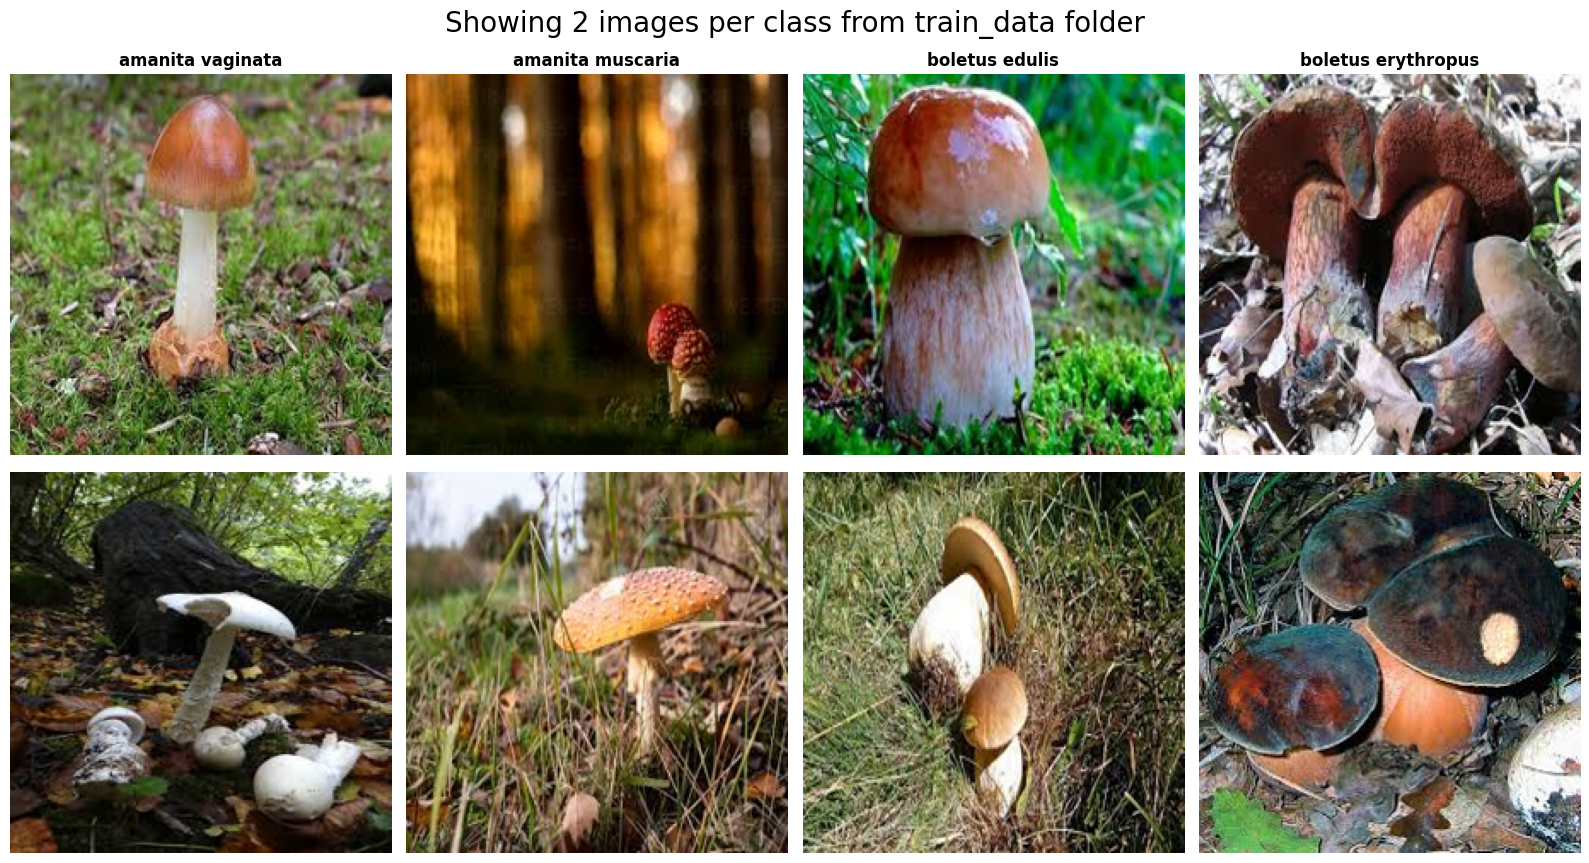

In [8]:
data.plot_random_images(data_path = data_path,
                   target_folder = "train_data",
                   img_per_classe = 2,
                   seed=False,
                   seed_num = 42,
                   img_size = (224,224),
                   plot_size=(16,9))